## Continuous Control ##

#### TRAIN A SINGLE DOUBLE JOINT ARMED AGENT TO REACH A MOVING TARGET ####

In [1]:
from unityagents import UnityEnvironment
import numpy as np

In [2]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display

In [3]:
import sys
sys.path.insert(0, './code/')
from ddptagent import Agent

In [4]:
import numpy as np
import random
import copy
from collections import namedtuple, deque
import torch

In [5]:
def show_graph(lq, avgs, mavgs, title="Training history", moving=False):
    plt.figure(figsize=(10,8))
    plt.plot(lq, ".", label="min")
    plt.plot(avgs, c="r", label="max")
    if moving==True:
        plt.plot(mavgs, c="g", label="mean")
        
    plt.axhline(y=30, color='m', linestyle='-.')
    plt.title(title)
    plt.legend()
    plt.show()

In [6]:
env = UnityEnvironment(file_name='Reacher.app')
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


#### CHECK THE ENVIRONMENT ####

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 1
Size of each action: 4
There are 1 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726671e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


In [8]:
def ddpg(n_episodes=500, max_t=1000, target_score=30.0, target_episodes=100, print_every=1, train_mode=True,
         actor_path='actor_chk.pt', critic_path='critic_chk.pt'):
    
    """Deep Deterministic Policy Gradient (DDPG)
    
    Params
    ======
        n_episodes (int)      : maximum number of training episodes
        max_t (int)           : maximum number of timesteps per episode
        train (bool)          : Train mode true or false
        target_score (float)  : min avg score over consecutive episodes
        target_episodes (int) : number of consecutive episodes used to calculate the score
        print_every (int)     : interval to display results
        actor_path (str)      : directory to store actor's weights
        critic_path (str)     : directory to store critic's weights

    """
    means = []                                # list to save mean scores
    min_s = []                                # list of lowests scores of each episode
    max_s = []                                # list of highest scores of each episode
    best_score = -1e10
    scoresDQ   = deque(maxlen=target_episodes)    # mean scores of n most recent episodes (n=target_episodes)
    mavs = []                                 # list of moving averages
    
    for episode_ist in range(1, n_episodes+1):
        env_info = env.reset(train_mode=train_mode)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent      
        agents_score = np.zeros(num_agents)                           # initialize score for each agent
        agent.reset()
        for t in range(max_t):
            actions = agent.act(states, add_noise=True)         # select an action
            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished
            # save experience to replay buffer, perform learning step at defined interval
            for state, action, reward, next_state, done in zip(states, actions, rewards, next_states, dones):
                agent.step(state, action, reward, next_state, done, t)             
            states = next_states
            agents_score += rewards        
            if np.any(dones):                                   # exit loop when episode ends
                break

        min_s.append(np.min(agents_score))
        max_s.append(np.max(agents_score))
        means.append(np.mean(agents_score))           
        scoresDQ.append(means[-1])                
        
        mavs.append(np.mean(scoresDQ))
        
        clear_output(wait=True)
        show_graph(min_s, max_s, means)
        print("scores mean", means)
                        
        if train_mode and means[-1] > best_score:
            torch.save(agent.actor_local.state_dict(), actor_path)
            torch.save(agent.critic_local.state_dict(), critic_path)
                  
        if mavs[-1] >= target_score and episode_ist >= target_episodes:
            print("Environment SOLVED in " + episode_ist + "episodes")
            print("Moving Average = " + mavs[-1] + " over last " + target_episodes + " episodes")
                  
            if train_mode:
                torch.save(agent.actor_local.state_dict(), actor_path)
                torch.save(agent.critic_local.state_dict(), critic_path)  
            break
            
    return means, mavs

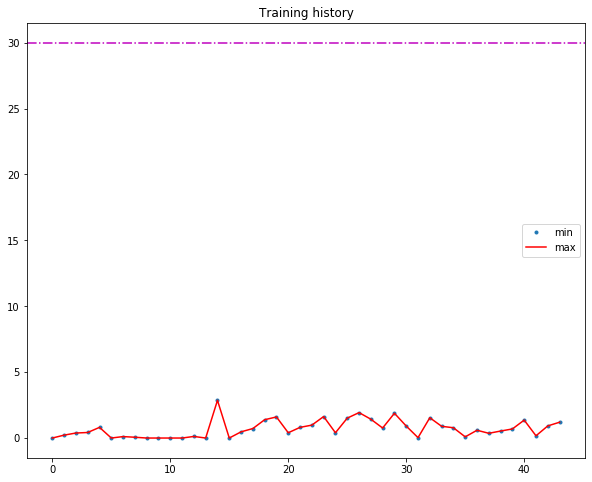

scores mean [0.0, 0.2199999950826168, 0.3799999915063381, 0.41999999061226845, 0.8099999818950891, 0.0, 0.1099999975413084, 0.05999999865889549, 0.0, 0.0, 0.0, 0.0, 0.11999999731779099, 0.0, 2.8599999360740185, 0.0, 0.46999998949468136, 0.7199999839067459, 1.389999968931079, 1.5999999642372131, 0.3999999910593033, 0.8099999818950891, 0.979999978095293, 1.6299999635666609, 0.3999999910593033, 1.50999996624887, 1.9299999568611383, 1.4299999680370092, 0.7599999830126762, 1.8799999579787254, 0.909999979659915, 0.029999999329447746, 1.5399999655783176, 0.8899999801069498, 0.7799999825656414, 0.08999999798834324, 0.5899999868124723, 0.35999999195337296, 0.5299999881535769, 0.6899999845772982, 1.3599999696016312, 0.1699999962002039, 0.9199999794363976, 1.1999999731779099]


In [ ]:
agent = Agent(state_size=state_size, action_size=action_size, random_seed=1)
scores, avgs = ddpg()

In [ ]:
env.close()